In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 134.70 MiB | 25.28 MiB/s, done.
Resolving deltas: 100% (376/376), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.9 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done


In [ ]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.6/717.6 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.5 MB/s eta 0:00:00


In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [ ]:
import os
import cv2
import torch
import numpy as np
import supervision as sv
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

In [ ]:
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

In [ ]:
# Load the milling tool image
IMAGE_PATH = "/content/drive/MyDrive/Images/8.jpg"  # Replace with your image path
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [ ]:
sam2_result = mask_generator.generate(image_rgb)

In [ ]:
import numpy as np

# Assuming sam2_result is a list of dictionaries with 'segmentation' and 'area' fields
masks = [entry['segmentation'] for entry in sam2_result]
areas = [entry['area'] for entry in sam2_result]

# Find the index of the largest area
largest_mask_index = np.argmax(areas)

# Extract the largest mask
largest_mask = masks[largest_mask_index]


In [ ]:
contours, _ = cv2.findContours(largest_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Wear region dimensions - Length: 1930, Width: 2592, Area: 2177513.5
Annotated image saved to /content/output/wear_region_annotated.jpg


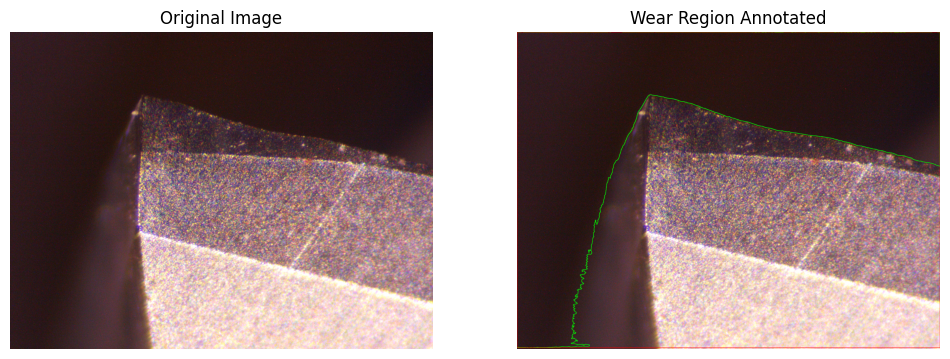

In [ ]:
# Calculate wear region dimensions and area
if contours:
    wear_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(wear_contour)
    area = cv2.contourArea(wear_contour)
    print(f"Wear region dimensions - Length: {h}, Width: {w}, Area: {area}")

    # Draw the wear region on the image
    annotated_image = image_bgr.copy()
    cv2.drawContours(annotated_image, [wear_contour], -1, (0, 255, 0), 2)  # Green contour
    cv2.rectangle(annotated_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red bounding box

    # Save and display the annotated image
    output_path = f"{HOME}/output/wear_region_annotated.jpg"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, annotated_image)
    print(f"Annotated image saved to {output_path}")

    sv.plot_images_grid(
        images=[image_bgr, annotated_image],
        grid_size=(1, 2),
        titles=['Original Image', 'Wear Region Annotated']
    )
else:
    print("No wear region detected in the image.")

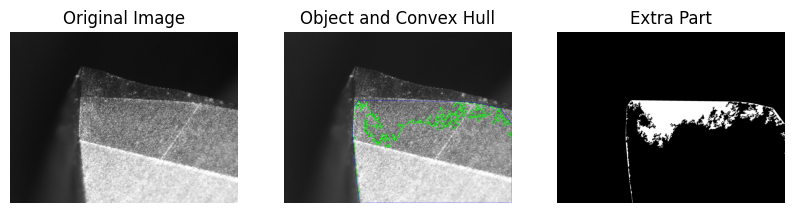

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (assuming it's in grayscale or you convert it to grayscale)
image = cv2.imread("/content/drive/MyDrive/Images/8.jpg", cv2.IMREAD_GRAYSCALE)

# Step 1: Threshold the image to segment the object (adjust threshold value as needed)
_, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Step 2: Find contours of the objects in the binary image
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 3: Create a mask to isolate the object (assuming it's the largest contour)
largest_contour = max(contours, key=cv2.contourArea)

# Step 4: Create a convex hull around the largest contour to approximate the object
hull = cv2.convexHull(largest_contour)

# Step 5: Draw the contours and the hull for visualization
output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(output_image, [largest_contour], -1, (0, 255, 0), 2)  # Original contour
cv2.drawContours(output_image, [hull], -1, (0, 0, 255), 2)  # Convex hull approximation

# Step 6: Find the extra part (difference between the convex hull and the original object)
hull_mask = np.zeros_like(image, dtype=np.uint8)
cv2.drawContours(hull_mask, [hull], -1, 255, thickness=cv2.FILLED)

# Mask of the original object
object_mask = np.zeros_like(image, dtype=np.uint8)
cv2.drawContours(object_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

# Step 7: Subtract the object from the hull to find the extra part
extra_part = cv2.subtract(hull_mask, object_mask)

# Step 8: Display the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(output_image)
plt.title("Object and Convex Hull")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(extra_part, cmap='gray')
plt.title("Extra Part")
plt.axis('off')

plt.show()


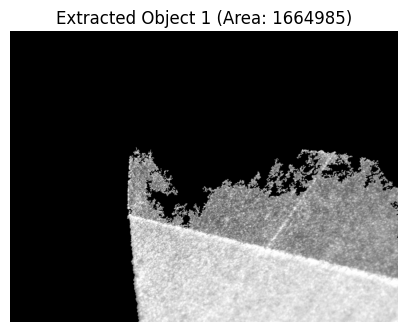

Top 10 largest objects saved to 'top_10_extracted_objects' directory.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the image (assuming it's in grayscale or you convert it to grayscale)
image = cv2.imread("/content/drive/MyDrive/Images/8.jpg", cv2.IMREAD_GRAYSCALE)

# Step 1: Threshold the image to segment the objects
_, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Step 2: Find contours of the objects in the binary image
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 3: Calculate the area of each contour
contour_areas = [(i, cv2.contourArea(contour)) for i, contour in enumerate(contours)]

# Step 4: Sort contours by area in descending order and pick top 10 largest
sorted_contours = sorted(contour_areas, key=lambda x: x[1], reverse=True)[:1]

# Create a directory to save the top 10 largest objects if it doesn't exist
output_dir = "top_10_extracted_objects"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Step 5: Process each of the top 10 largest contours
for idx, (i, area) in enumerate(sorted_contours):
    # Get the contour for the current largest object
    contour = contours[i]

    # Step 6: Create a mask for the current object
    object_mask = np.zeros_like(image, dtype=np.uint8)
    cv2.drawContours(object_mask, [contour], -1, 255, thickness=cv2.FILLED)

    # Step 7: Apply the mask to the original image to extract the object
    extracted_object = cv2.bitwise_and(image, image, mask=object_mask)

    # Step 8: Save the extracted object as an image
    output_image_path = os.path.join(output_dir, f"object_{idx + 1}_area_{int(area)}.png")
    cv2.imwrite(output_image_path, extracted_object)

    # Optional: Display the extracted object (can be removed if not needed)
    plt.figure(figsize=(5, 5))
    plt.imshow(extracted_object, cmap='gray')
    plt.title(f"Extracted Object {idx + 1} (Area: {int(area)})")
    plt.axis('off')
    plt.show()

print(f"Top 10 largest objects saved to '{output_dir}' directory.")


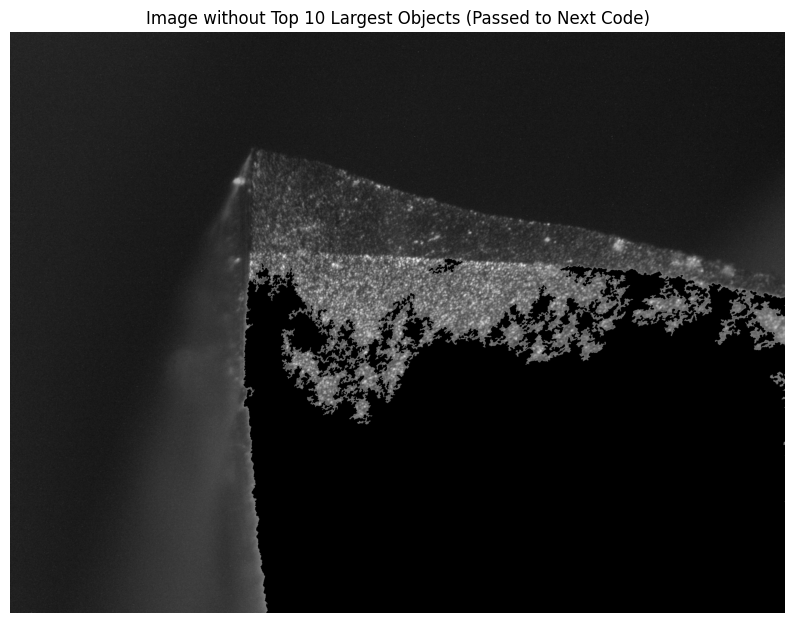

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the original image (assuming it's in grayscale or you convert it to grayscale)
IMAGE_PATH = "/content/drive/MyDrive/Images/8.jpg"  # Replace with your image path
image = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# Step 1: Threshold the image to segment the objects
_, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Step 2: Find contours of the objects in the binary image
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 3: Calculate the area of each contour
contour_areas = [(i, cv2.contourArea(contour)) for i, contour in enumerate(contours)]

# Step 4: Sort contours by area in descending order and pick top 10 largest
sorted_contours = sorted(contour_areas, key=lambda x: x[1], reverse=True)[:10]

# Step 5: Create a mask for all the top 10 largest objects
mask = np.ones_like(image, dtype=np.uint8) * 255  # Start with a white mask (background)
for idx, (i, area) in enumerate(sorted_contours):
    contour = contours[i]
    # Create a mask for each object and subtract it from the background
    object_mask = np.zeros_like(image, dtype=np.uint8)
    cv2.drawContours(object_mask, [contour], -1, 255, thickness=cv2.FILLED)
    # Subtract each object mask from the mask
    mask = cv2.subtract(mask, object_mask)

# Step 6: The remaining image is the one without the top 10 largest objects
remaining_image = cv2.bitwise_and(image, image, mask=mask)

# --- Pass the remaining_image to your next code section ---

# Convert remaining image to BGR for consistency in the next code block
remaining_image_bgr = cv2.cvtColor(remaining_image, cv2.COLOR_GRAY2BGR)

# Next: Load the milling tool image
image_bgr = remaining_image_bgr  # Pass the remaining_image directly as input
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Display the resulting image
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.title("Image without Top 10 Largest Objects (Passed to Next Code)")
plt.axis('off')
plt.show()

# The remaining image is now ready to be processed further in your next code section.


In [ ]:
sam2_result = mask_generator.generate(image_rgb)

In [ ]:
import numpy as np

# Assuming sam2_result is a list of dictionaries with 'segmentation' and 'area' fields
masks = [entry['segmentation'] for entry in sam2_result]
areas = [entry['area'] for entry in sam2_result]

# Find the index of the largest area
largest_mask_index = np.argmax(areas)

# Extract the largest mask
largest_mask = masks[largest_mask_index]


In [ ]:
contours, _ = cv2.findContours(largest_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


Wear region dimensions - Length: 137, Width: 102, Area: 7526.0
Annotated image saved to /content/output/wear_region_annotated.jpg


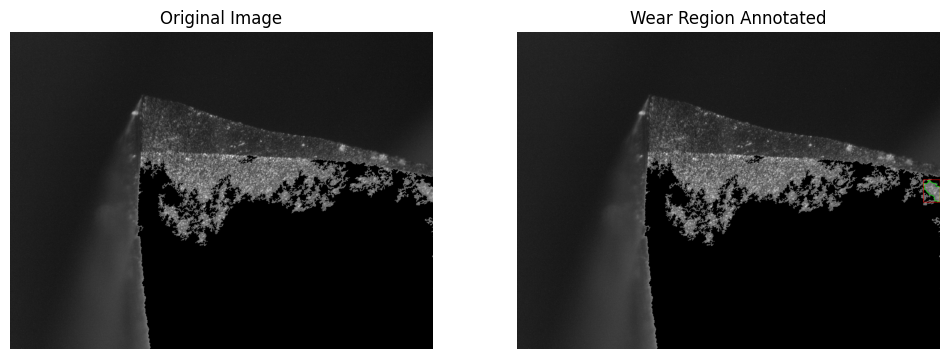

In [ ]:
# Calculate wear region dimensions and area
if contours:
    wear_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(wear_contour)
    area = cv2.contourArea(wear_contour)
    print(f"Wear region dimensions - Length: {h}, Width: {w}, Area: {area}")

    # Draw the wear region on the image
    annotated_image = image_bgr.copy()
    cv2.drawContours(annotated_image, [wear_contour], -1, (0, 255, 0), 2)  # Green contour
    cv2.rectangle(annotated_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red bounding box

    # Save and display the annotated image
    output_path = f"{HOME}/output/wear_region_annotated.jpg"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, annotated_image)
    print(f"Annotated image saved to {output_path}")

    sv.plot_images_grid(
        images=[image_bgr, annotated_image],
        grid_size=(1, 2),
        titles=['Original Image', 'Wear Region Annotated']
    )
else:
    print("No wear region detected in the image.")

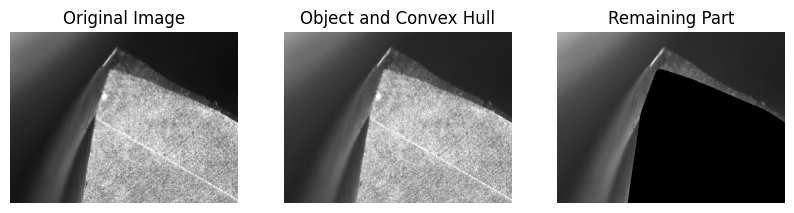

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (assuming it's in grayscale or you convert it to grayscale)
image = cv2.imread("/content/drive/MyDrive/Images/16.jpg", cv2.IMREAD_GRAYSCALE)

# Step 1: Threshold the image to segment the object
_, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Step 2: Find contours of the objects in the binary image
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 3: Create a mask to isolate the object (assuming it's the largest contour)
largest_contour = max(contours, key=cv2.contourArea)

# Step 4: Create a convex hull around the largest contour to approximate the object
hull = cv2.convexHull(largest_contour)

# Step 5: Create masks for the largest contour and convex hull
object_mask = np.zeros_like(image, dtype=np.uint8)
cv2.drawContours(object_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

hull_mask = np.zeros_like(image, dtype=np.uint8)
cv2.drawContours(hull_mask, [hull], -1, 255, thickness=cv2.FILLED)

# Step 6: Subtract the object and convex hull area from the original image
# We need to create a mask that covers the object and convex hull area to be removed
combined_mask = cv2.bitwise_or(object_mask, hull_mask)

# Step 7: Subtract the combined mask from the original image to get the remaining part
remaining_image = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(combined_mask))

# Display the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR))  # Displaying original image in color for comparison
plt.title("Object and Convex Hull")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(remaining_image, cmap='gray')
plt.title("Remaining Part")
plt.axis('off')

plt.show()

# The remaining_image now contains the image with the object and convex hull removed.


In [ ]:
# Next: Load the milling tool image
image_bgr = remaining_image  # Pass the remaining_image directly as input
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [ ]:
sam2_result = mask_generator.generate(image_rgb)

In [ ]:
import numpy as np

# Assuming sam2_result is a list of dictionaries with 'segmentation' and 'area' fields
masks = [entry['segmentation'] for entry in sam2_result]
areas = [entry['area'] for entry in sam2_result]

# Find the index of the largest area
largest_mask_index = np.argmax(areas)

# Extract the largest mask
largest_mask = masks[largest_mask_index]


In [ ]:
contours, _ = cv2.findContours(largest_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


Wear region dimensions - Length: 1520, Width: 1786, Area: 2138875.5
Annotated image saved to /content/output/wear_region_annotated.jpg


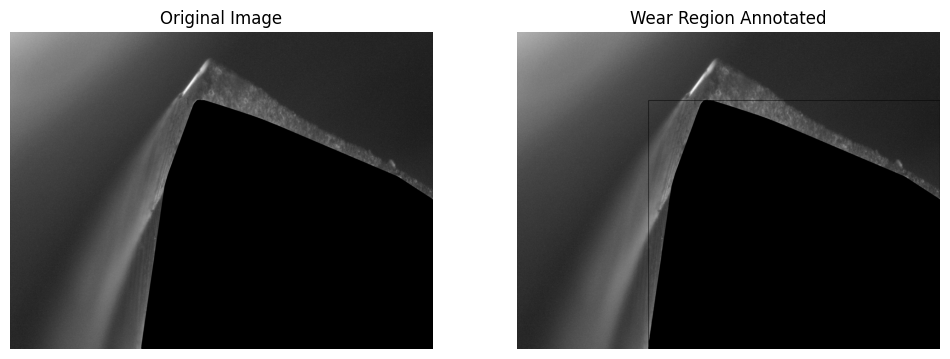

In [ ]:
# Calculate wear region dimensions and area
if contours:
    wear_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(wear_contour)
    area = cv2.contourArea(wear_contour)
    print(f"Wear region dimensions - Length: {h}, Width: {w}, Area: {area}")

    # Draw the wear region on the image
    annotated_image = image_bgr.copy()
    cv2.drawContours(annotated_image, [wear_contour], -1, (0, 255, 0), 2)  # Green contour
    cv2.rectangle(annotated_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red bounding box

    # Save and display the annotated image
    output_path = f"{HOME}/output/wear_region_annotated.jpg"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, annotated_image)
    print(f"Annotated image saved to {output_path}")

    sv.plot_images_grid(
        images=[image_bgr, annotated_image],
        grid_size=(1, 2),
        titles=['Original Image', 'Wear Region Annotated']
    )
else:
    print("No wear region detected in the image.")

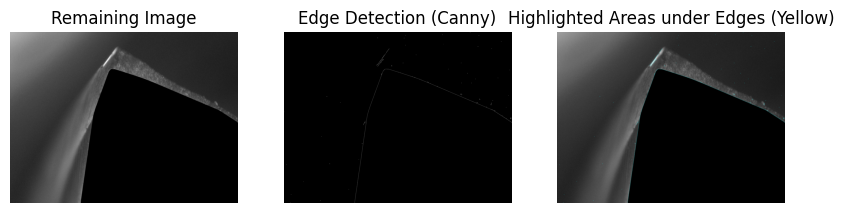

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the remaining image (image with the object and convex hull removed)
# Assume remaining_image is already obtained as the output from your previous steps

# Step 1: Apply edge detection (Canny)
edges = cv2.Canny(remaining_image, 50, 150)

# Step 2: Convert the remaining image to color (BGR) for visualization
remaining_image_color = cv2.cvtColor(remaining_image, cv2.COLOR_GRAY2BGR)

# Step 3: Create a mask from the edges
# We will consider the edges as the mask and highlight those areas
yellow = (0, 255, 255)  # Yellow color in BGR format

# Step 4: Highlight the areas under the edges with yellow color
remaining_image_color[edges == 255] = yellow  # Set pixels corresponding to edges to yellow

# Step 5: Display the results
plt.figure(figsize=(10, 10))

# Show the original remaining image in grayscale
plt.subplot(1, 3, 1)
plt.imshow(remaining_image, cmap='gray')
plt.title("Remaining Image")
plt.axis('off')

# Show the edges detected on the image
plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection (Canny)")
plt.axis('off')

# Show the image with areas under edges highlighted in yellow
plt.subplot(1, 3, 3)
plt.imshow(remaining_image_color)
plt.title("Highlighted Areas under Edges (Yellow)")
plt.axis('off')

plt.show()
